In [148]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import mlpp.pp.hawkes as hk
from whma.metrics import rel_err, rank_corr, mse_K_part
from whma.cumulants import Cumulants, get_C_claw, get_K_part_th
from numba import autojit

In [149]:
d = 10
mus = 0.0005 * np.ones(d)
Alpha_true = np.zeros((d,d))
Beta = np.zeros((d,d))
for i in range(5):
    for j in range(5):
        if i <= j:
            Alpha_true[i][j] = 1.
            Beta[i][j] = 50.
for i in range(5,10):
    for j in range(5,10):
        if i >= j:
            Alpha_true[i][j] = 1.
            Beta[i][j] = 1.
Alpha_true /= 6

In [150]:
_, s, _ = np.linalg.svd(Alpha_true)
print(s.max())
assert s.max() < 1, "Alpha_true cannot generate a stable Hawkes process"

0.585556181944


### Trick for exp kernel to assess $\beta_\min$ 

* We want: $$\exp(-\beta H) = \frac{1}{1000} \mbox{ for all }\beta \ge \beta_\min$$

In [151]:
hMax = 40
hDelta = .01
from math import log
# the criteria for beta_min and beta_max are designed for the exponential case
beta_min = log(1000) / hMax
print("We have")
print("    beta_min = ",beta_min)

We have
    beta_min =  0.17269388197455343


In [152]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_true, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mus))
T_max = 100000000
h.simulate(T_max)

# Use the class Cumulants

In [153]:
N = h.get_full_process()
cumul = Cumulants(N,hMax=16)
cumul.compute_all_part()

In [154]:
from scipy.linalg import inv
R_true = inv(np.eye(d)-Alpha_true)
cumul.set_C_th(R_true)
cumul.set_K_part_th(R_true)

# Minimize MSE on full third order integrated cumulant

In [155]:
objective = lambda R: np.linalg.norm(cumul.K_part - get_K_part_th(cumul.L,cumul.C,R))**2

### L-BFGS doesn't work since the problem is non-convex

In [156]:
from scipy.optimize import fmin_l_bfgs_b
res = fmin_l_bfgs_b(objective,np.random.rand(d**2),approx_grad=1)
R_lbfgs = res[0].reshape(d,d)

In [157]:
print(rel_err(R_true,np.zeros((d,d))))
print(rel_err(R_true,R_lbfgs))

0.3
0.330021281684


# Nesterov Accelerated Gradient

### I've added regularization on $R$: nuclear norm to find a low-rank $||\Phi||$

In [194]:
from whma.prox import prox_nuclear, prox_l1
eta = 1e4
lbd_l1 = 1e-6
lbd_nuc = 1e-6
n_iter = 10000

In [195]:
#R0_ = np.arange(d**2).reshape(d,d)/(d**2)
R0_ = np.ones((d,d))

from whma.optim import inspector, nag, gd
nag_inspector = inspector(objective,R_true,n_iter=n_iter)
grad_fun = lambda X: gradient_g(X,cumul.L,cumul.C,cumul.K_part)
R_nag = nag(R0_,grad_fun,n_iter=n_iter,step=eta,prox=prox_nuclear,lbd=lbd_nuc,callback=nag_inspector)

### Plot objective over time

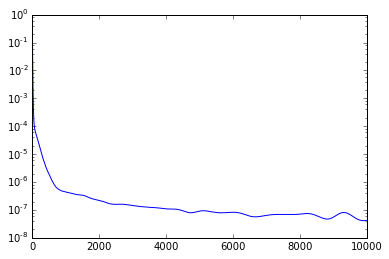

In [196]:
plt.plot(nag_inspector.obj)
plt.yscale('log')

### Plot relative error over time

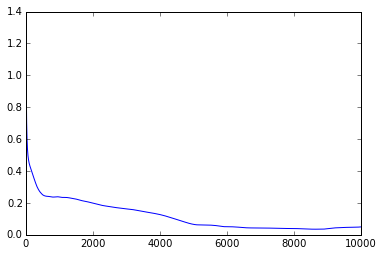

In [197]:
plt.plot(nag_inspector.err)

In [198]:
print(rel_err(R_true,np.zeros((d,d))))
print(rel_err(R_true,R_nag))

0.3
0.0494347553507


# Heatmaps

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


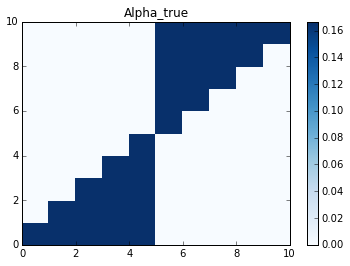

In [205]:
Alpha_pred = np.eye(d) - inv(R_nag)

plt.pcolor(Alpha_true,cmap=plt.cm.Blues)
plt.title("Alpha_true")
plt.colorbar()
plt.show()
plt.close()

0.0544909122175
0.522352802053


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


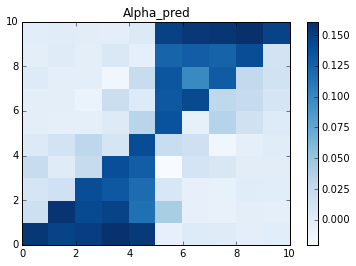

In [206]:
print(rel_err(Alpha_true,Alpha_pred))
_, s, _ = np.linalg.svd(Alpha_pred)
print(s.max())

#Alpha_pred[Alpha_pred <= 0.] = 0.

plt.pcolor(Alpha_pred,cmap=plt.cm.Blues)
plt.title("Alpha_pred")
plt.colorbar()
plt.show()
plt.close()

In [207]:
print(rel_err(Alpha_true,Alpha_pred))

0.0544909122175


/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


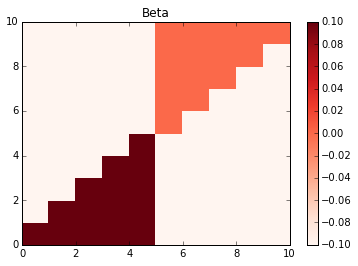

In [208]:
plt.pcolor(np.log(Beta),cmap=plt.cm.Reds)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()